In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, GlobalAveragePooling2D, BatchNormalization, MaxPool2D, LeakyReLU, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix , accuracy_score
import cv2
from keras import backend as K
import numpy as np
from numpy import argmax
import sys
import tensorflow as tf
from keras.preprocessing import image

color = sns.color_palette()
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [0]:
# Define path to the data directory
data_dir = Path('./drive/My Drive/X-ray_ML')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,drive/My Drive/X-ray_ML/train/NORMAL/IM-0461-0...,0
1,drive/My Drive/X-ray_ML/train/NORMAL/NORMAL2-I...,0
2,drive/My Drive/X-ray_ML/train/PNEUMONIA/person...,1
3,drive/My Drive/X-ray_ML/train/PNEUMONIA/person...,1
4,drive/My Drive/X-ray_ML/train/PNEUMONIA/person...,1


In [6]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 1)


In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,1), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
              
           # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = [label]
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = [label]
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = [label]
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [9]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = 0
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = 1
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels).reshape(-1,1)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 1)


In [10]:
 model_InceptionV3 = load_model('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_InceptionV3_v1.h5')
# model_InceptionV3.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)
model_InceptionV3.load_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_InceptionV3_v1.h5')













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [11]:
model_custom = load_model('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_custom_v2.h5',compile=False)
model_custom.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='adam')
model_custom.load_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_custom_v2.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model_Xception = load_model('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_Xception_v1.h5')
# model_Xception.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)
model_Xception.load_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_Xception_v1.h5')

In [0]:
# model_ResNet50 = load_model('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_ResNet50_v1.h5')
# model_ResNet50.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)
# model_ResNet50.load_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_ResNet50_v1.h5')

In [13]:
models = [model_InceptionV3, model_custom, model_Xception]
model_name = ['InceptionV3','Custom_Model','Xception']
model_accuracy = []
for model in models:
  _, acc = model.evaluate(test_data, test_labels)
  model_accuracy.append(acc)

624/624 [==============================] - 7s 11ms/step


In [18]:
for i in range(len(models)):
  print("Accuracy on test set of " + model_name[i] + " : ", model_accuracy[i])

Accuracy on test set of InceptionV3 :  0.8189102564102564
Accuracy on test set of Custom_Model :  0.9022435897435898
Accuracy on test set of Xception :  0.8782051282051282


In [0]:
# create dataset for stacked model
def stacked_dataset(models, test_data):
  stackX = None
  for model in models:
    pred = model.predict(test_data, verbose=0)
    if stackX is None:
      stackX = pred
    else:
      stackX = np.dstack((stackX, pred))
  stackX = stackX.reshape((stackX.shape[0],stackX.shape[1]*stackX.shape[2]))
  return stackX


In [0]:
# fit a stacked model
def fit_stacked_model(models, stackedX, test_data, test_labels):
  inputs = Input(shape=(3,))
  x = Dense(512, activation='relu')(inputs)
  x = Dropout(rate=0.7)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(rate=0.3)(x)
  output = Dense(1, activation='sigmoid')(x)
  stacked_model = Model(inputs=inputs, outputs=output)
  stacked_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  stacked_model.fit(stackedX,test_labels,epochs=5000)
  return stacked_model

In [0]:
# prediction of stacked model
def stacked_prediction(models, stacked_model, test_data):
  stackedX = stacked_dataset(models, test_data)
  stacked_pred = stacked_model.predict(stackedX)
  return stacked_pred

In [0]:
stackedX = stacked_dataset(models, test_data)

In [29]:
stacked_model = fit_stacked_model(models, stackedX, test_data, test_labels)

Epoch 1/5000
624/624 [==============================] - 4s 7ms/step - loss: 0.5823 - acc: 0.5929
Epoch 2/5000
624/624 [==============================] - 0s 150us/step - loss: 0.5051 - acc: 0.7115
Epoch 3/5000
624/624 [==============================] - 0s 152us/step - loss: 0.4499 - acc: 0.8510
Epoch 4/5000
624/624 [==============================] - 0s 136us/step - loss: 0.3613 - acc: 0.9006
Epoch 5/5000
624/624 [==============================] - 0s 153us/step - loss: 0.3126 - acc: 0.9151
Epoch 6/5000
624/624 [==============================] - 0s 150us/step - loss: 0.2800 - acc: 0.9151
Epoch 7/5000
624/624 [==============================] - 0s 147us/step - loss: 0.2765 - acc: 0.9279
Epoch 8/5000
624/624 [==============================] - 0s 141us/step - loss: 0.2546 - acc: 0.9199
Epoch 9/5000
624/624 [==============================] - 0s 164us/step - loss: 0.2677 - acc: 0.9135
Epoch 10/5000
624/624 [==============================] - 0s 136us/step - loss: 0.2676 - acc: 0.9151
Epoch 11/50

In [0]:
stacked_pred = stacked_prediction(models, stacked_model, test_data)

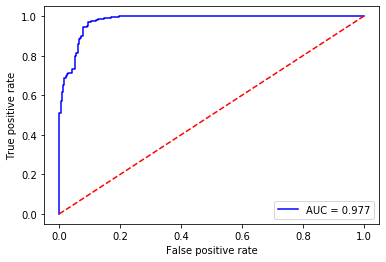

In [34]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
fpr, tpr, threshold = roc_curve(test_labels,stacked_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'b',label='AUC = %0.3f' % roc_auc)
plt.legend(loc= 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [35]:
y_pred = np.where(stacked_pred >= 0.5, 1, 0)
target_names = ['Control', 'Pnemonia']
print(classification_report(test_labels, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Control       0.95      0.90      0.93       234
    Pnemonia       0.94      0.97      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.94       624
weighted avg       0.95      0.95      0.95       624



In [0]:
stacked_model.save('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_stacked_3.h5')
stacked_model.save_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_stacked_3.h5')

In [0]:
predicts = []
models = [model_InceptionV3, model_custom, model_Xception]
for model in models:
  temp_pred = model.predict(test_data)
  predicts.append(temp_pred)
predicts.append(stacked_pred)

In [0]:
model_name = ['InceptionV3','Custom_Model','Xception','Stacked']
all_fpr = []
all_tpr = []
all_roc_auc = []
for i in range (len(model_name)):
  fpr, tpr, _ = roc_curve(test_labels,predicts[i])
  roc_auc = auc(fpr, tpr)
  all_fpr.append(fpr)
  all_tpr.append(tpr)
  all_roc_auc.append(roc_auc)
  plt.ylabel('True positive rate')
  plt.xlabel('False positive rate')
  plt.plot(all_fpr[i],all_tpr[i],label = 'Model %s , AUC = %0.3f' % (model_name[i],all_roc_auc[i]))
  plt.legend(loc= 'lower right')
